# Plot a Map of the Anegada Passage Region with glider transects

In [1]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.geoaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import numpy as np
import glob
import datetime
import xarray as xr
import cmocean.cm as cmo

myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%y/%m/%d\n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

# Load data
## 2020 first

In [2]:
dz=10
path = "/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/Processed_{}_meter_vertical_resolution/".format(dz)
files = np.sort(glob.glob(path+'*.csv'))
df = pd.concat(map(pd.read_csv, files))


inversion_dz = np.diff(df.inversion_depth)[0].astype(int)
inversion_depth         = np.arange(np.min(df.inversion_depth),np.max(df.inversion_depth)+inversion_dz,inversion_dz)
inversion_time          = np.empty(len(files))
inversion_time[:]       = np.NaN
inversion_time          = inversion_time.astype(pd.Timestamp)
inversion_start_time    = np.empty(len(files))
inversion_start_time[:] = np.NaN
inversion_start_time    = inversion_time.astype(pd.Timestamp)
inversion_end_time      = np.empty(len(files))
inversion_end_time[:]   = np.NaN
inversion_end_time      = inversion_time.astype(pd.Timestamp)
inversion_lat           = np.empty(len(files))
inversion_lat[:]        = np.NaN
inversion_lon           = np.empty(len(files))
inversion_lon[:]        = np.NaN
inversion_start_lat     = np.empty(len(files))
inversion_start_lat[:]  = np.NaN
inversion_start_lon     = np.empty(len(files))
inversion_start_lon[:]  = np.NaN
inversion_end_lat       = np.empty(len(files))
inversion_end_lat[:]    = np.NaN
inversion_end_lon       = np.empty(len(files))
inversion_end_lon[:]    = np.NaN
u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    
    inversion_start_time[x] = pd.to_datetime(df.start_tm[0]).tz_localize(None)
    inversion_end_time[x] = pd.to_datetime(df.end_tm[0]).tz_localize(None)
    mid_time = inversion_end_time[x]-inversion_start_time[x]
    
    inversion_time[x] = inversion_start_time[x]+mid_time

    inversion_start_lat[x] = df.start_lat[0]
    inversion_start_lon[x] = df.start_lon[0]
    inversion_end_lat[x]   = df.end_lat[0]
    inversion_end_lon[x]   = df.end_lon[0]
    ## Lat/lon mid point
    inversion_lat[x]   = (df.start_lat[0]+df.end_lat[0])/2
    inversion_lon[x]   = (df.start_lon[0]+df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
ds_2020 = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        latitude   = (["time"], inversion_lat),
        longitude  = (["time"], inversion_lon),
        start_lat  = (["time"], inversion_start_lat),
        start_lon  = (["time"], inversion_start_lon),
        end_lat    = (["time"], inversion_end_lat),
        end_lon    = (["time"], inversion_end_lon),
        start_time = (["time"], inversion_start_time),
        end_time   = (["time"], inversion_end_time)
    ),
    coords=dict(
        time  = inversion_time,
        depth = inversion_depth
    ),
    attrs=dict(description="Master/combined RU29 2020 AD2CP least-squares inversion velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
ds_2020 = ds_2020.sortby(ds_2020.time)
ds_2020

<xarray.Dataset>
Dimensions:     (depth: 98, time: 242)
Coordinates:
  * time        (time) datetime64[ns] 2020-10-02T04:20:23.550000 ... 2020-11-...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 945.0 955.0 965.0 975.0
Data variables:
    u_grid      (depth, time) float64 -0.2862 -0.3009 -0.2237 ... -0.00483 nan
    v_grid      (depth, time) float64 0.01931 0.06462 0.1457 ... 0.005272 nan
    latitude    (time) float64 18.03 18.05 18.07 18.1 ... 18.04 18.01 17.98
    longitude   (time) float64 -64.81 -64.81 -64.81 ... -64.79 -64.79 -64.8
    start_lat   (time) float64 18.01 18.04 18.06 18.09 ... 18.06 18.03 18.0
    start_lon   (time) float64 -64.81 -64.81 -64.81 ... -64.79 -64.79 -64.79
    end_lat     (time) float64 18.04 18.06 18.09 18.11 ... 18.03 18.0 17.97
    end_lon     (time) float64 -64.81 -64.81 -64.81 ... -64.79 -64.79 -64.8
    start_time  (time) datetime64[ns] 2020-10-02T01:15:52.840000 ... 2020-11-...
    end_time    (time) datetime64[ns] 2020-10-02T04:20:23.550000 ... 2020-11-...
Attributes:
    description:  Master/combined RU29 2020 AD2CP least-squares inversion vel...

In [3]:
# delta = ds_2022.time.values.max()-ds_2022.time.values.min()
# delta.astype('timedelta64[D]')

## Then 2021 a

In [4]:
dz=10
path = "/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_1_AD2CP_NC/Processed_{}_meter_vertical_resolution/".format(dz)
#path = "/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/RU_29/2021_Mission_1_Processed_Velocity_Profiles/"
files = np.sort(glob.glob(path+'*.csv'))
df = pd.concat(map(pd.read_csv, files))


inversion_depth         = np.arange(np.min(df.inversion_depth),np.max(df.inversion_depth)+dz,dz)
inversion_time          = np.empty(len(files))
inversion_time[:]       = np.NaN
inversion_time          = inversion_time.astype(pd.Timestamp)
inversion_start_time    = np.empty(len(files))
inversion_start_time[:] = np.NaN
inversion_start_time    = inversion_time.astype(pd.Timestamp)
inversion_end_time      = np.empty(len(files))
inversion_end_time[:]   = np.NaN
inversion_end_time      = inversion_time.astype(pd.Timestamp)
inversion_lat           = np.empty(len(files))
inversion_lat[:]        = np.NaN
inversion_lon           = np.empty(len(files))
inversion_lon[:]        = np.NaN
inversion_start_lat     = np.empty(len(files))
inversion_start_lat[:]  = np.NaN
inversion_start_lon     = np.empty(len(files))
inversion_start_lon[:]  = np.NaN
inversion_end_lat       = np.empty(len(files))
inversion_end_lat[:]    = np.NaN
inversion_end_lon       = np.empty(len(files))
inversion_end_lon[:]    = np.NaN
u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    
    inversion_start_time[x] = pd.to_datetime(df.start_tm[0]).tz_localize(None)
    inversion_end_time[x] = pd.to_datetime(df.end_tm[0]).tz_localize(None)
    mid_time = inversion_end_time[x]-inversion_start_time[x]
    
    inversion_time[x] = inversion_start_time[x]+mid_time

    inversion_start_lat[x] = df.start_lat[0]
    inversion_start_lon[x] = df.start_lon[0]
    inversion_end_lat[x]   = df.end_lat[0]
    inversion_end_lon[x]   = df.end_lon[0]
    ## Lat/lon mid point
    inversion_lat[x]   = (df.start_lat[0]+df.end_lat[0])/2
    inversion_lon[x]   = (df.start_lon[0]+df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
ds_2021_a = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        latitude   = (["time"], inversion_lat),
        longitude  = (["time"], inversion_lon),
        start_lat  = (["time"], inversion_start_lat),
        start_lon  = (["time"], inversion_start_lon),
        end_lat    = (["time"], inversion_end_lat),
        end_lon    = (["time"], inversion_end_lon),
        start_time = (["time"], inversion_start_time),
        end_time   = (["time"], inversion_end_time)
    ),
    coords=dict(
        time  = inversion_time,
        depth = inversion_depth
    ),
    attrs=dict(description="Master/combined RU29 2021 Mission 1 AD2CP least-squares inversion velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
ds_2021_a = ds_2021_a.sortby(ds_2021_a.time)
ds_2021_a


<xarray.Dataset>
Dimensions:     (depth: 98, time: 113)
Coordinates:
  * time        (time) datetime64[ns] 2021-06-30T14:30:55 ... 2021-07-14T11:1...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 945.0 955.0 965.0 975.0
Data variables:
    u_grid      (depth, time) float64 -0.1183 -0.07372 -0.05783 ... nan nan nan
    v_grid      (depth, time) float64 -0.0172 0.04695 0.006812 ... nan nan nan
    latitude    (time) float64 18.17 18.17 18.16 18.15 ... 18.15 18.15 18.15
    longitude   (time) float64 -64.83 -64.83 -64.81 ... -63.81 -63.82 -63.83
    start_lat   (time) float64 18.17 18.17 18.16 18.15 ... 18.15 18.15 18.15
    start_lon   (time) float64 -64.83 -64.83 -64.82 ... -63.8 -63.82 -63.83
    end_lat     (time) float64 18.17 18.16 18.15 18.14 ... 18.15 18.15 18.14
    end_lon     (time) float64 -64.83 -64.82 -64.8 ... -63.82 -63.83 -63.83
    start_time  (time) datetime64[ns] 2021-06-30T13:43:52 ... 2021-07-14T10:2...
    end_time    (time) datetime64[ns] 2021-06-30T14:30:55 ... 2021-07-14T11:1...
Attributes:
    description:  Master/combined RU29 2021 Mission 1 AD2CP least-squares inv...

## Then 2021 b

In [5]:
dz=10
path = "/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_2_AD2CP_NC/Processed_{}_meter_vertical_resolution/".format(dz)
files = np.sort(glob.glob(path+'*.csv'))
df = pd.concat(map(pd.read_csv, files))

inversion_depth         = np.arange(np.min(df.inversion_depth),np.max(df.inversion_depth)+dz,dz)
inversion_time          = np.empty(len(files))
inversion_time[:]       = np.NaN
inversion_time          = inversion_time.astype(pd.Timestamp)
inversion_start_time    = np.empty(len(files))
inversion_start_time[:] = np.NaN
inversion_start_time    = inversion_time.astype(pd.Timestamp)
inversion_end_time      = np.empty(len(files))
inversion_end_time[:]   = np.NaN
inversion_end_time      = inversion_time.astype(pd.Timestamp)
inversion_lat           = np.empty(len(files))
inversion_lat[:]        = np.NaN
inversion_lon           = np.empty(len(files))
inversion_lon[:]        = np.NaN
inversion_start_lat     = np.empty(len(files))
inversion_start_lat[:]  = np.NaN
inversion_start_lon     = np.empty(len(files))
inversion_start_lon[:]  = np.NaN
inversion_end_lat       = np.empty(len(files))
inversion_end_lat[:]    = np.NaN
inversion_end_lon       = np.empty(len(files))
inversion_end_lon[:]    = np.NaN
u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    
    inversion_start_time[x] = pd.to_datetime(df.start_tm[0]).tz_localize(None)
    inversion_end_time[x] = pd.to_datetime(df.end_tm[0]).tz_localize(None)
    mid_time = inversion_end_time[x]-inversion_start_time[x]
    
    inversion_time[x] = inversion_start_time[x]+mid_time

    inversion_start_lat[x] = df.start_lat[0]
    inversion_start_lon[x] = df.start_lon[0]
    inversion_end_lat[x]   = df.end_lat[0]
    inversion_end_lon[x]   = df.end_lon[0]
    ## Lat/lon mid point
    inversion_lat[x]   = (df.start_lat[0]+df.end_lat[0])/2
    inversion_lon[x]   = (df.start_lon[0]+df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
ds_2021_b = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        latitude   = (["time"], inversion_lat),
        longitude  = (["time"], inversion_lon),
        start_lat  = (["time"], inversion_start_lat),
        start_lon  = (["time"], inversion_start_lon),
        end_lat    = (["time"], inversion_end_lat),
        end_lon    = (["time"], inversion_end_lon),
        start_time = (["time"], inversion_start_time),
        end_time   = (["time"], inversion_end_time)
    ),
    coords=dict(
        time  = inversion_time,
        depth = inversion_depth
    ),
    attrs=dict(description="Master/combined RU29 2021 Mission 2 AD2CP least-squares inversion velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
ds_2021_b = ds_2021_b.sortby(ds_2021_b.time)
ds_2021_b


<xarray.Dataset>
Dimensions:     (depth: 102, time: 219)
Coordinates:
  * time        (time) datetime64[ns] 2021-09-08T20:04:03.520000 ... 2021-10-...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 995.0 1.005e+03 1.015e+03
Data variables:
    u_grid      (depth, time) float64 -0.141 0.007458 -0.04472 ... nan nan nan
    v_grid      (depth, time) float64 0.03683 0.05545 0.03476 ... nan nan nan
    latitude    (time) float64 18.17 18.17 18.16 18.14 ... 18.15 18.16 18.16
    longitude   (time) float64 -64.97 -64.97 -64.97 ... -64.81 -64.81 -64.81
    start_lat   (time) float64 18.17 18.17 18.17 18.15 ... 18.15 18.16 18.16
    start_lon   (time) float64 -64.97 -64.97 -64.97 ... -64.81 -64.81 -64.81
    end_lat     (time) float64 18.17 18.17 18.15 18.12 ... 18.16 18.16 18.16
    end_lon     (time) float64 -64.97 -64.97 -64.97 ... -64.81 -64.81 -64.81
    start_time  (time) datetime64[ns] 2021-09-08T19:43:16.840000 ... 2021-10-...
    end_time    (time) datetime64[ns] 2021-09-08T20:04:03.520000 ... 2021-10-...
Attributes:
    description:  Master/combined RU29 2021 Mission 2 AD2CP least-squares inv...

## Then 2022

In [6]:
dz = 10

path = "/home/jg1200/Data/GliderData/RU36/RU36_03_2022_ADCP_Processed_csv/{}_meter_vertical_resolution/".format(dz)
files = np.sort(glob.glob(path+'*.csv'))
inversion_df = pd.concat(map(pd.read_csv, files))


inversion_depth         = np.arange(2.5,1030,dz)
inversion_time          = np.empty(len(files))
inversion_time[:]       = np.NaN
inversion_time          = inversion_time.astype(pd.Timestamp)
inversion_start_time    = np.empty(len(files))
inversion_start_time[:] = np.NaN
inversion_start_time    = inversion_time.astype(pd.Timestamp)
inversion_end_time      = np.empty(len(files))
inversion_end_time[:]   = np.NaN
inversion_end_time      = inversion_time.astype(pd.Timestamp)
inversion_lat           = np.empty(len(files))
inversion_lat[:]        = np.NaN
inversion_lon           = np.empty(len(files))
inversion_lon[:]        = np.NaN
inversion_start_lat     = np.empty(len(files))
inversion_start_lat[:]  = np.NaN
inversion_start_lon     = np.empty(len(files))
inversion_start_lon[:]  = np.NaN
inversion_end_lat       = np.empty(len(files))
inversion_end_lat[:]    = np.NaN
inversion_end_lon       = np.empty(len(files))
inversion_end_lon[:]    = np.NaN
u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    inversion_df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(inversion_df.inversion_u.values)),x] = inversion_df.inversion_u.values
    v_grid[np.arange(0,len(inversion_df.inversion_v.values)),x] = inversion_df.inversion_v.values
    
    inversion_start_time[x] = pd.to_datetime(inversion_df.start_tm[0]).tz_localize(None)
    inversion_end_time[x] = pd.to_datetime(inversion_df.end_tm[0]).tz_localize(None)
    mid_time = inversion_end_time[x]-inversion_start_time[x]
    
    inversion_time[x] = inversion_start_time[x]+mid_time

    inversion_start_lat[x] = inversion_df.start_lat[0]
    inversion_start_lon[x] = inversion_df.start_lon[0]
    inversion_end_lat[x]   = inversion_df.end_lat[0]
    inversion_end_lon[x]   = inversion_df.end_lon[0]
    ## Lat/lon mid point
    inversion_lat[x]   = (inversion_df.start_lat[0]+inversion_df.end_lat[0])/2
    inversion_lon[x]   = (inversion_df.start_lon[0]+inversion_df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
ds_2022 = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        latitude   = (["time"], inversion_lat),
        longitude  = (["time"], inversion_lon),
        start_lat  = (["time"], inversion_start_lat),
        start_lon  = (["time"], inversion_start_lon),
        end_lat    = (["time"], inversion_end_lat),
        end_lon    = (["time"], inversion_end_lon),
        start_time = (["time"], inversion_start_time),
        end_time   = (["time"], inversion_end_time)
    ),
    coords=dict(
        time  = inversion_time,
        depth = inversion_depth
    ),
    attrs=dict(description="Master/combined RU36 2022 RDI ADCP least-squares inversion velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
ds_2022 = ds_2022.sortby(ds_2022.time)
ds_2022

<xarray.Dataset>
Dimensions:     (depth: 103, time: 108)
Coordinates:
  * time        (time) datetime64[ns] 2022-02-24T20:07:10.130000 ... 2022-03-...
  * depth       (depth) float64 2.5 12.5 22.5 ... 1.002e+03 1.012e+03 1.022e+03
Data variables:
    u_grid      (depth, time) float64 -0.435 -0.5904 -0.5977 ... nan nan nan
    v_grid      (depth, time) float64 -0.04313 0.09993 0.08711 ... nan nan nan
    latitude    (time) float64 18.15 18.15 18.15 18.15 ... 17.87 17.84 17.83
    longitude   (time) float64 -64.8 -64.8 -64.8 -64.8 ... -64.81 -64.81 -64.8
    start_lat   (time) float64 18.15 18.15 18.15 18.15 ... 17.88 17.85 17.83
    start_lon   (time) float64 -64.79 -64.8 -64.8 -64.8 ... -64.81 -64.81 -64.81
    end_lat     (time) float64 18.15 18.15 18.15 18.15 ... 17.85 17.83 17.84
    end_lon     (time) float64 -64.8 -64.8 -64.8 -64.8 ... -64.81 -64.81 -64.8
    start_time  (time) datetime64[ns] 2022-02-24T18:29:31.830000 ... 2022-03-...
    end_time    (time) datetime64[ns] 2022-02-24T20:07:10.130000 ... 2022-03-...
Attributes:
    description:  Master/combined RU36 2022 RDI ADCP least-squares inversion ...

## Subset to just the transects used in analysis

In [7]:
sect_times1 = pd.read_csv('/home/jg1200/Data/GliderData/RU29/anagada_section_times.csv')
sect_times1.starttime = np.array(sect_times1.starttime,dtype=np.datetime64)
sect_times1.endtime = np.array(sect_times1.endtime,dtype=np.datetime64)
sect_times = sect_times1.iloc[7:-1,:]

subset_ds_2020 = ds_2020.sel(time=slice(sect_times.starttime.values[0], sect_times.endtime.values[-1]))
subset_ds_2020

<xarray.Dataset>
Dimensions:     (depth: 98, time: 174)
Coordinates:
  * time        (time) datetime64[ns] 2020-10-15T09:45:53.970000 ... 2020-11-...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 945.0 955.0 965.0 975.0
Data variables:
    u_grid      (depth, time) float64 0.08747 -0.1253 ... -0.007726 -0.0004271
    v_grid      (depth, time) float64 -0.006903 0.04306 ... 0.004158 0.0002135
    latitude    (time) float64 17.83 17.84 17.87 17.89 ... 18.06 18.1 18.13
    longitude   (time) float64 -64.8 -64.8 -64.8 -64.8 ... -64.79 -64.79 -64.79
    start_lat   (time) float64 17.83 17.82 17.85 17.88 ... 18.05 18.08 18.11
    start_lon   (time) float64 -64.8 -64.8 -64.8 -64.8 ... -64.79 -64.79 -64.79
    end_lat     (time) float64 17.82 17.85 17.88 17.91 ... 18.08 18.11 18.14
    end_lon     (time) float64 -64.8 -64.8 -64.8 -64.8 ... -64.79 -64.79 -64.79
    start_time  (time) datetime64[ns] 2020-10-15T06:42:04.870000 ... 2020-11-...
    end_time    (time) datetime64[ns] 2020-10-15T09:45:53.970000 ... 2020-11-...
Attributes:
    description:  Master/combined RU29 2020 AD2CP least-squares inversion vel...

In [8]:
subset_ds_2021_a = ds_2021_a.sel(time=slice("2021-07-04 15:00:00","2021-07-09 23:59:00"))
subset_ds_2021_a

<xarray.Dataset>
Dimensions:     (depth: 98, time: 39)
Coordinates:
  * time        (time) datetime64[ns] 2021-07-04T17:09:48 ... 2021-07-09T22:0...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 945.0 955.0 965.0 975.0
Data variables:
    u_grid      (depth, time) float64 0.04838 0.03983 0.001043 ... nan nan nan
    v_grid      (depth, time) float64 0.0412 0.00962 0.02406 ... nan nan nan
    latitude    (time) float64 18.42 18.43 18.43 18.43 ... 18.34 18.35 18.35
    longitude   (time) float64 -64.31 -64.28 -64.25 ... -63.41 -63.39 -63.37
    start_lat   (time) float64 18.41 18.43 18.43 18.43 ... 18.34 18.34 18.35
    start_lon   (time) float64 -64.32 -64.3 -64.26 ... -63.42 -63.4 -63.38
    end_lat     (time) float64 18.43 18.43 18.43 18.43 ... 18.34 18.35 18.35
    end_lon     (time) float64 -64.3 -64.26 -64.23 ... -63.4 -63.38 -63.36
    start_time  (time) datetime64[ns] 2021-07-04T14:28:32 ... 2021-07-09T19:5...
    end_time    (time) datetime64[ns] 2021-07-04T17:09:48 ... 2021-07-09T22:0...
Attributes:
    description:  Master/combined RU29 2021 Mission 1 AD2CP least-squares inv...

In [9]:
subset_ds_2021_b = ds_2021_b.sel(time=slice("2021-09-14 00:00:00","2021-09-18 11:00:00"))
subset_ds_2021_b

<xarray.Dataset>
Dimensions:     (depth: 102, time: 34)
Coordinates:
  * time        (time) datetime64[ns] 2021-09-14T00:14:57.040000 ... 2021-09-...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 995.0 1.005e+03 1.015e+03
Data variables:
    u_grid      (depth, time) float64 -0.01947 -0.03801 ... -0.03111 -0.02026
    v_grid      (depth, time) float64 -0.07167 -0.07763 ... 0.000288 -0.005673
    latitude    (time) float64 18.08 18.08 18.08 18.07 ... 17.96 17.95 17.95
    longitude   (time) float64 -64.79 -64.76 -64.73 ... -63.98 -63.95 -63.93
    start_lat   (time) float64 18.08 18.08 18.08 18.07 ... 17.96 17.95 17.95
    start_lon   (time) float64 -64.8 -64.78 -64.74 ... -63.99 -63.97 -63.94
    end_lat     (time) float64 18.08 18.08 18.07 18.06 ... 17.95 17.95 17.95
    end_lon     (time) float64 -64.78 -64.74 -64.72 ... -63.97 -63.94 -63.91
    start_time  (time) datetime64[ns] 2021-09-13T20:52:52.120000 ... 2021-09-...
    end_time    (time) datetime64[ns] 2021-09-14T00:14:57.040000 ... 2021-09-...
Attributes:
    description:  Master/combined RU29 2021 Mission 2 AD2CP least-squares inv...

## Need to do 2022 dataset manually

In [10]:
start_ind2 = '2022-03-01 03:50:37'
end_ind2   = '2022-03-02 13:07:40'

start_ind3 = '2022-03-02 16:23:19'
end_ind3   = '2022-03-03 22:10:11'

start_ind4 = '2022-03-03 22:10:11'
end_ind4   = '2022-03-05 06:43:08'

start_ind5 = '2022-03-05 06:43:08'
end_ind5   = '2022-03-06 15:50:51'

start_ind6 = '2022-03-06 15:50:51'
end_ind6   = '2022-03-08 01:36:52'

start_ind7 = '2022-03-08 01:36:52'
end_ind7   = '2022-03-09 11:18:04'

transect_start_times = [start_ind2, start_ind3, start_ind4, start_ind5, start_ind6, start_ind7]
transect_end_times   = [end_ind2, end_ind3, end_ind4, end_ind5, end_ind6, end_ind7]

subset_ds_2022 = ds_2022.sel(time=slice(transect_start_times[0], transect_end_times[-1]))
subset_ds_2022


<xarray.Dataset>
Dimensions:     (depth: 103, time: 58)
Coordinates:
  * time        (time) datetime64[ns] 2022-03-01T03:51:23.670000 ... 2022-03-...
  * depth       (depth) float64 2.5 12.5 22.5 ... 1.002e+03 1.012e+03 1.022e+03
Data variables:
    u_grid      (depth, time) float64 0.069 0.0107 -0.2023 ... nan nan nan
    v_grid      (depth, time) float64 -0.1054 0.2886 0.4248 ... nan nan nan
    latitude    (time) float64 17.84 17.84 17.87 17.9 ... 17.96 17.93 17.9 17.87
    longitude   (time) float64 -64.81 -64.8 -64.79 ... -64.81 -64.81 -64.81
    start_lat   (time) float64 17.85 17.82 17.85 17.89 ... 17.94 17.91 17.88
    start_lon   (time) float64 -64.81 -64.8 -64.79 ... -64.81 -64.81 -64.81
    end_lat     (time) float64 17.82 17.85 17.89 17.92 ... 17.91 17.88 17.85
    end_lon     (time) float64 -64.8 -64.79 -64.79 ... -64.81 -64.81 -64.81
    start_time  (time) datetime64[ns] 2022-03-01T00:41:14.270000 ... 2022-03-...
    end_time    (time) datetime64[ns] 2022-03-01T03:51:23.670000 ... 2022-03-...
Attributes:
    description:  Master/combined RU36 2022 RDI ADCP least-squares inversion ...

## Load Bathymetry Data

In [2]:
fname = 'https://gamone.whoi.edu/thredds/dodsC/usgs/data0/bathy/ETOPO2v2c_f4.nc'
ds_etpo = xr.open_dataset(fname)   

## Plot it up

/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


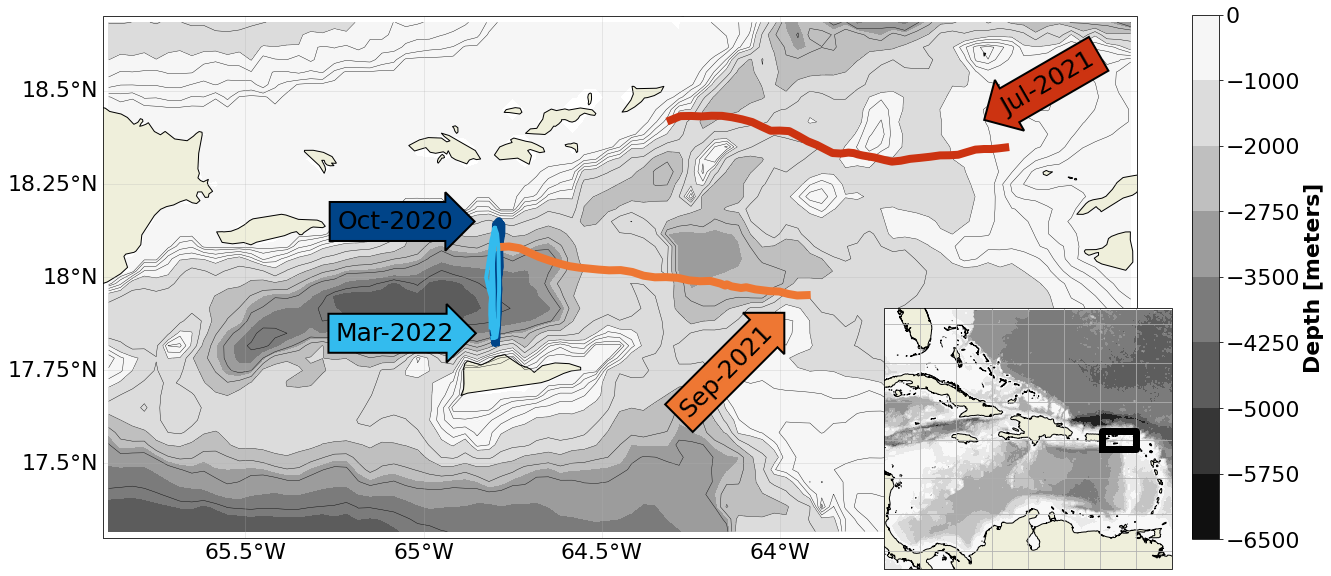

In [15]:
fig, ax = plt.subplots(figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))

## Set lon and lat ranges
lon1 = -65.9
lon2 = -63
lat1 = 17.3
lat2 = 18.7

ax.set_extent([lon1, lon2, lat1, lat2])
## Isobars to plot
#lvl = [-4000, -3000, -2500, -2000, -1500, -1000, -750, -500, -400, -300, -200, -100]
lvl = [-4000, -3000, -2500, -2000, -1500, -1000, -750, -500, -250, -100]

## Depth contours to plot
#dpth_contours = np.array([-6500, -5000,-4000, -3000, -2000, -1000,0])
dpth_contours = np.array([-6500, -5750,-5000,-4250,-3500,-2750,-2000, -1000,0])
## Subset bathymetry
region = ds_etpo.sel(x=slice(lon1, lon2), y=slice(lat1, lat2))

# bathy = ax.contourf(region.x, region.y, region.z,levels=50,  cmap='Blues_r' ,  transform=ccrs.PlateCarree(), vmin=-3000, vmax=0, zorder=0)
bathy = ax.contourf(region.x, region.y, region.z,  cmap='Greys_r' ,  transform=ccrs.PlateCarree(), levels=dpth_contours, zorder=0)
ax.contour(region.x, region.y, region.z, levels= lvl, colors='k', linestyles='solid', linewidths=.4,  transform=ccrs.PlateCarree())


LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor=cfeature.COLORS['land']
)

ax.add_feature(LAND, zorder=0)

glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
glb.xlabel_style = {'size': 22}
glb.ylabel_style = {'size': 22}
glb.ylocator = mticker.FixedLocator([17, 17.25, 17.5, 17.75, 18, 18.25, 18.5, 18.75])
glb.xlocator = mticker.FixedLocator([-65.5,-65,-64.5,-64])


########### Set colors here to carry through
## Sarah
# oct_2020_color = 'mediumorchid'
# jul_2021_color = 'orange'
# sep_2021_color = 'orangered'
# mar_2022_color = 'greenyellow'

# Paul Tol # I think I like this BEST!
# oct_2020_color = '#0077BB'
# jul_2021_color = '#BB5566'
# sep_2021_color = '#DDAA33'
# mar_2022_color = '#009988'


oct_2020_color = '#004488'
sep_2021_color = '#EE7733'
jul_2021_color = '#CC3311'
mar_2022_color = '#33BBEE'


ax.plot(subset_ds_2020.longitude, subset_ds_2020.latitude,linewidth=8, linestyle='-',transform=ccrs.PlateCarree(),color=oct_2020_color,label='Oct-2020')
ax.plot(subset_ds_2021_a.longitude, subset_ds_2021_a.latitude,linewidth=8,linestyle= '-',transform=ccrs.PlateCarree(),color=jul_2021_color)
ax.plot(subset_ds_2021_b.longitude, subset_ds_2021_b.latitude,linewidth=8, linestyle='-',transform=ccrs.PlateCarree(),color=sep_2021_color)
ax.plot(subset_ds_2022.longitude, subset_ds_2022.latitude,linewidth=4, linestyle='-',transform=ccrs.PlateCarree(),color=mar_2022_color,label='Mar-2022')

cbar = plt.colorbar(bathy,pad=0.05, fraction=0.0235)
cbar.set_label(label='Depth [meters]', size=22, weight='bold')
cbar.ax.tick_params(labelsize=22)

## Trying another projection
## Add a small, zoomed out map for context
## bbox_to_anchor(left, bottom, width, height)
axins = inset_axes(ax, width="28%", height="50%",
                   bbox_to_anchor=(0.04, -0.55, 1, 1),
                   bbox_transform=ax.transAxes,
                   axes_class=cartopy.mpl.geoaxes.GeoAxes,
                   axes_kwargs=dict(map_projection=ccrs.Mercator(central_longitude=-65.5)))

## Extent of inset map
lon1_big = -84
lon2_big = -60
lat1_big = 7.5
lat2_big = 28
axins.set_extent([lon1_big, lon2_big, lat1_big, lat2_big])

## Box around actual figure region
axins.plot([lon1, lon1,  lon2, lon2, lon1] , 
                        [lat1, lat2, lat2, lat1, lat1 ], color='black',linewidth=7,  transform=ccrs.PlateCarree(), zorder=100 )
axins.add_feature(LAND, zorder=0)
axins.gridlines(linewidths=.5)

region = ds_etpo.sel(x=slice(lon1_big, lon2_big), y=slice(lat1_big, lat2_big))
## Similar to the main plot but just a tad deeper
dpth_contours = np.array([-9000,-7000,-5750,-5000,-4250,-3500,-2750,-2000, -1000,0])

## inset bathy
axins.contourf(region.x, region.y, region.z,levels=dpth_contours,  cmap='Greys_r' ,  transform=ccrs.PlateCarree(), zorder=0)


## Draw arrow labels
transform = ccrs.PlateCarree()._as_mpl_transform(ax)
ax.text(
    -65.08, 17.85, "Mar-2022", ha="center", va="center", rotation=0, size=25,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc=mar_2022_color, ec="black", lw=2),transform=transform)
ax.text(
    -65.08, 18.15, "Oct-2020", ha="center", va="center", rotation=0, size=25,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc=oct_2020_color, ec="black", lw=2),transform=transform)
ax.text(
    -64.15, 17.75, "Sep-2021", ha="center", va="center", rotation=45, size=25,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc=sep_2021_color, ec="black", lw=2),transform=transform)
ax.text(
    -63.25, 18.52, "Jul-2021", ha="center", va="center", rotation=30, size=25,
    bbox=dict(boxstyle="larrow,pad=0.3", fc=jul_2021_color, ec="black", lw=2),transform=transform)

plt.savefig('/home/jg1200/Figures/RU29_2020_2022_Anegada_Map_greys.png',dpi=300,facecolor='white',bbox_inches='tight')


## Plain with bathymetry

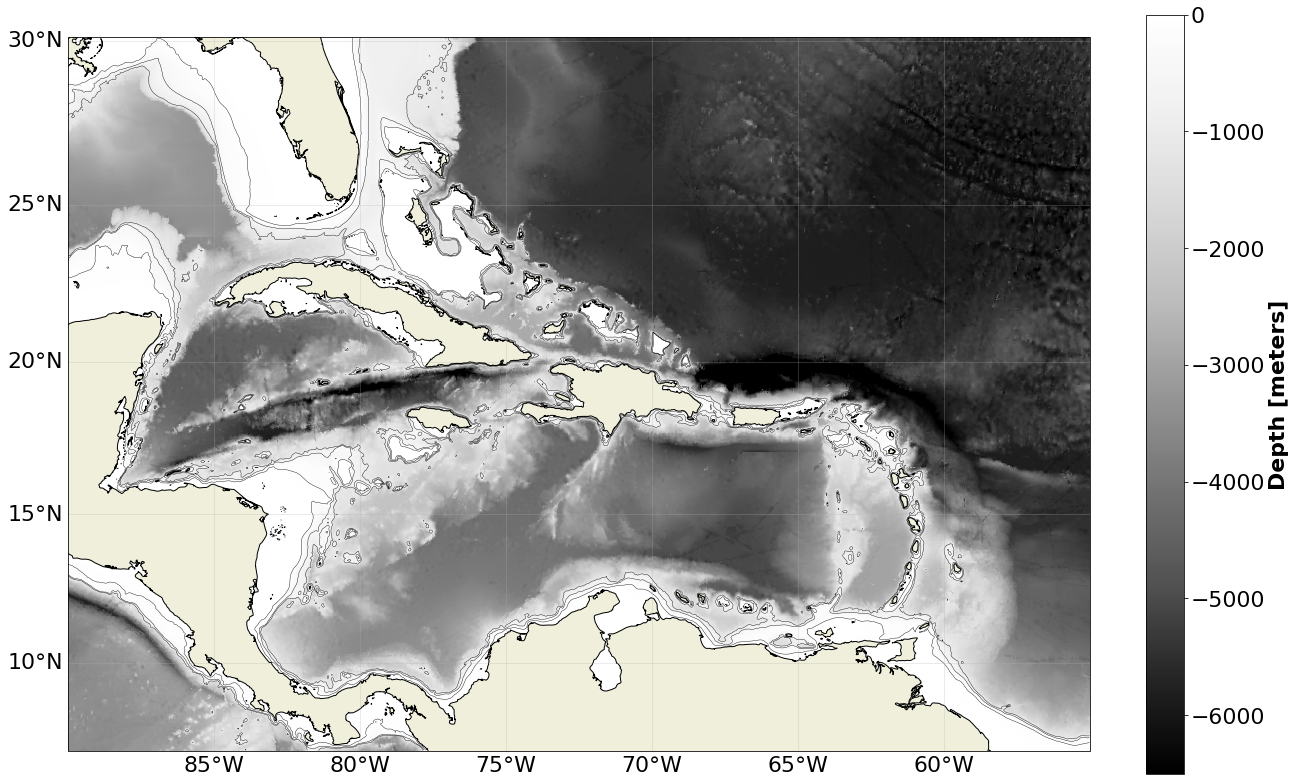

In [31]:
fig, ax = plt.subplots(figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))

## Set lon and lat ranges
lon1 = -90
lon2 = -55
lat1 = 7
lat2 = 30.1

ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())


## Isobars to plot
lvl = [-1000, -500, -100]
## Depth contours to plot
dpth_contours = np.arange(-7000,1,1000)

## Subset bathymetry
region = ds_etpo.sel(x=slice(lon1, lon2), y=slice(lat1, lat2))
bathy = ax.pcolormesh(region.x, region.y, region.z,  cmap='Greys_r' ,  transform=ccrs.PlateCarree(), vmin=-6500,vmax=0, zorder=0)
ax.contour(region.x, region.y, region.z, levels= lvl, colors='k', linestyles='solid', linewidths=.4,  transform=ccrs.PlateCarree())

LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor=cfeature.COLORS['land']
)

ax.add_feature(LAND, zorder=0)

glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
glb.xlabel_style = {'size': 22}
glb.ylabel_style = {'size': 22}
glb.ylocator = mticker.FixedLocator([10, 15, 20, 25, 30])

cbar = plt.colorbar(bathy,pad=0.05, fraction=0.034)
cbar.set_label(label='Depth [meters]', size=22, weight='bold')
cbar.ax.tick_params(labelsize=22)

plt.savefig('/home/jg1200/Figures/BLANK_CARIB_MAP_bathy.png',dpi=300,facecolor='white',bbox_inches='tight')


## Plain without bathymetry

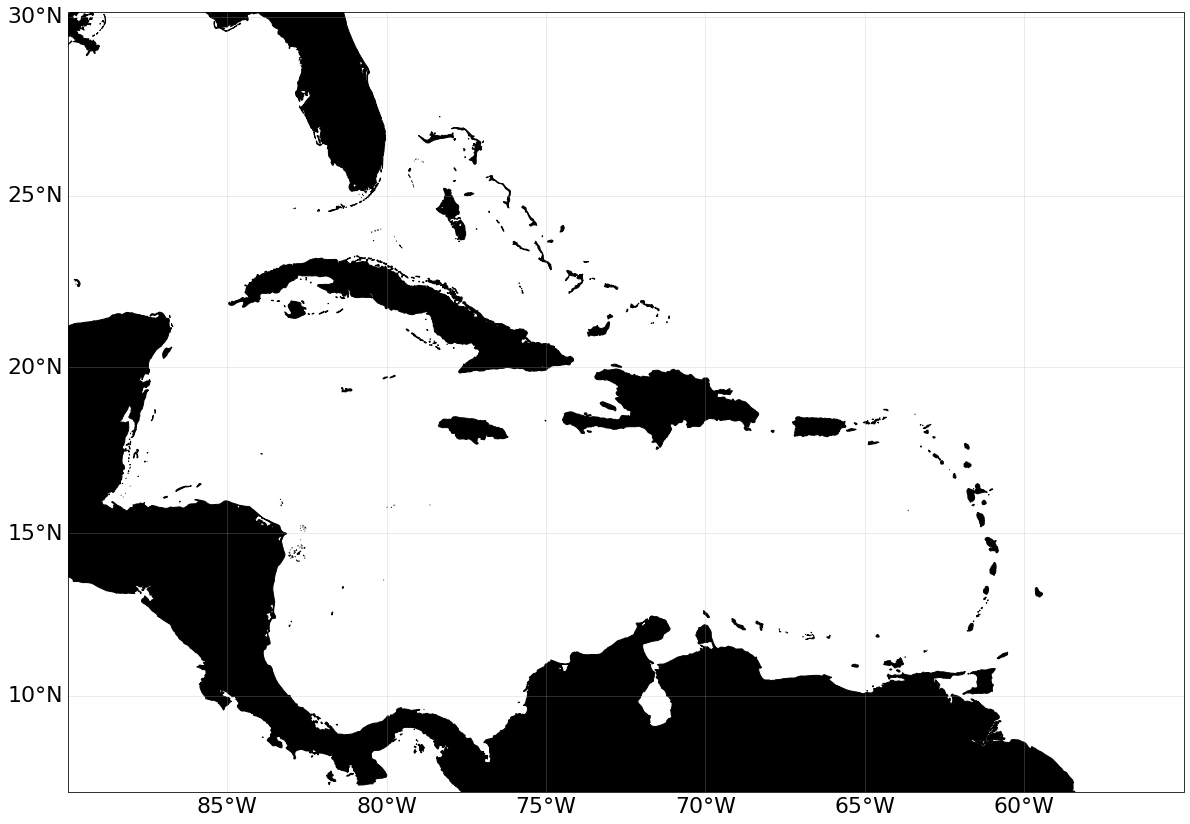

In [193]:
fig, ax = plt.subplots(figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))

## Set lon and lat ranges
lon1 = -90
lon2 = -55
lat1 = 7
lat2 = 29

ax.set_extent([lon1, lon2, lat1, lat2])

LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor='black'
)

ax.add_feature(LAND, zorder=0)

glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
glb.xlabel_style = {'size': 22}
glb.ylabel_style = {'size': 22}
glb.ylocator = mticker.FixedLocator([10, 15, 20, 25, 30])


plt.savefig('/home/jg1200/Figures/BLANK_CARIB_MAP.png',dpi=300,facecolor='white',bbox_inches='tight')


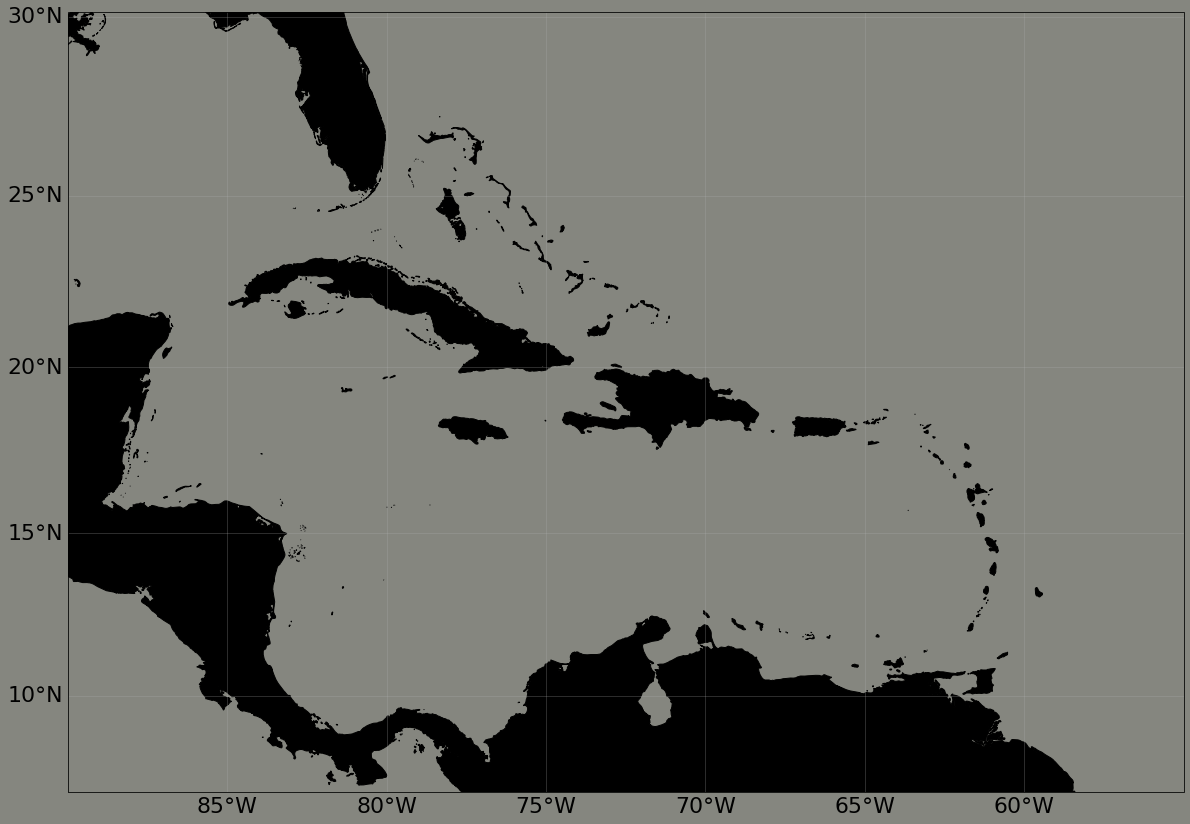

In [7]:
new_color='#85867f'


fig, ax = plt.subplots(figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()),facecolor=new_color)

## Set lon and lat ranges
lon1 = -90
lon2 = -55
lat1 = 7
lat2 = 29

ax.set_facecolor(new_color)

ax.set_extent([lon1, lon2, lat1, lat2])

LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor='black'
)

ax.add_feature(LAND, zorder=0)

glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
glb.xlabel_style = {'size': 22}
glb.ylabel_style = {'size': 22}
glb.ylocator = mticker.FixedLocator([10, 15, 20, 25, 30])


plt.savefig('/home/jg1200/Figures/BLANK_CARIB_MAP_TAN.png',dpi=300,facecolor=new_color,bbox_inches='tight')


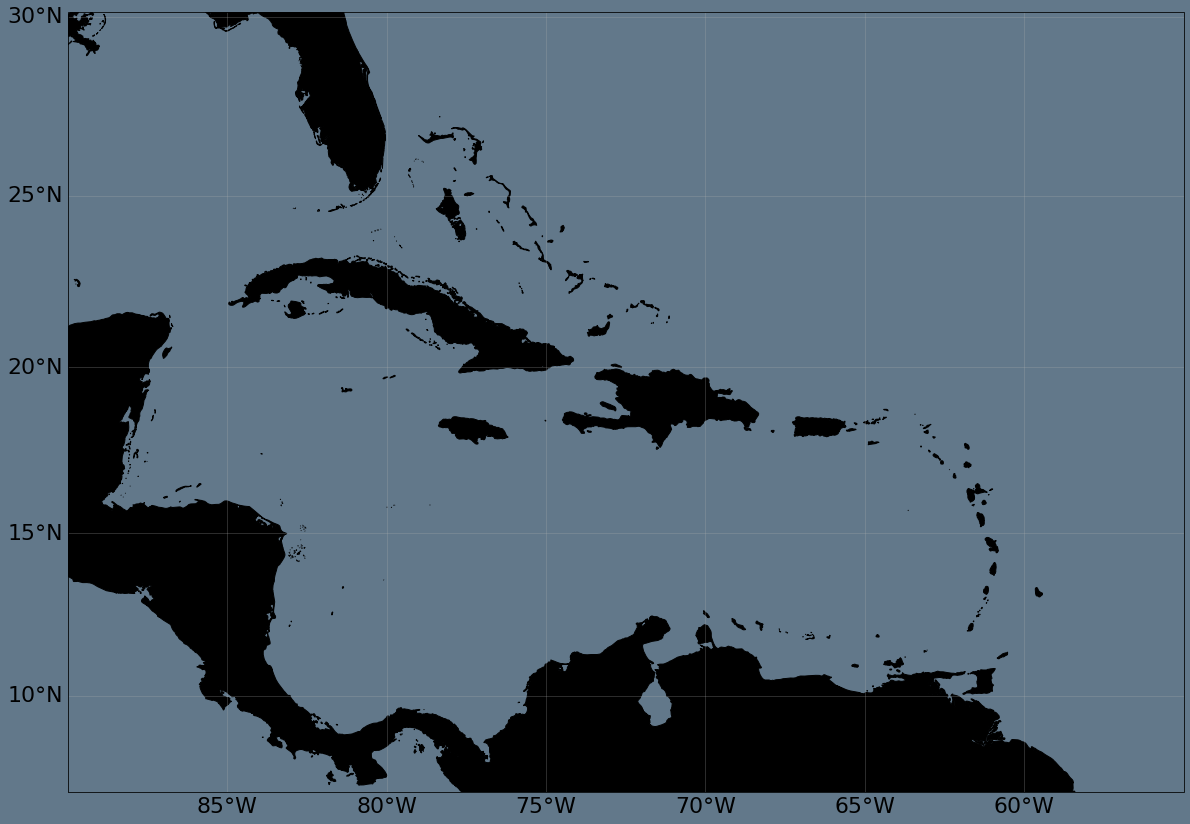

In [8]:
new_color='#62788a'


fig, ax = plt.subplots(figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()),facecolor=new_color)

## Set lon and lat ranges
lon1 = -90
lon2 = -55
lat1 = 7
lat2 = 29

ax.set_facecolor(new_color)

ax.set_extent([lon1, lon2, lat1, lat2])

LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor='black'
)

ax.add_feature(LAND, zorder=0)

glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
glb.xlabel_style = {'size': 22}
glb.ylabel_style = {'size': 22}
glb.ylocator = mticker.FixedLocator([10, 15, 20, 25, 30])


plt.savefig('/home/jg1200/Figures/BLANK_CARIB_MAP_GREY.png',dpi=300,facecolor=new_color,bbox_inches='tight')


/home/jg1200/.conda/envs/glider_3_9/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/jg1200/.conda/envs/glider_3_9/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


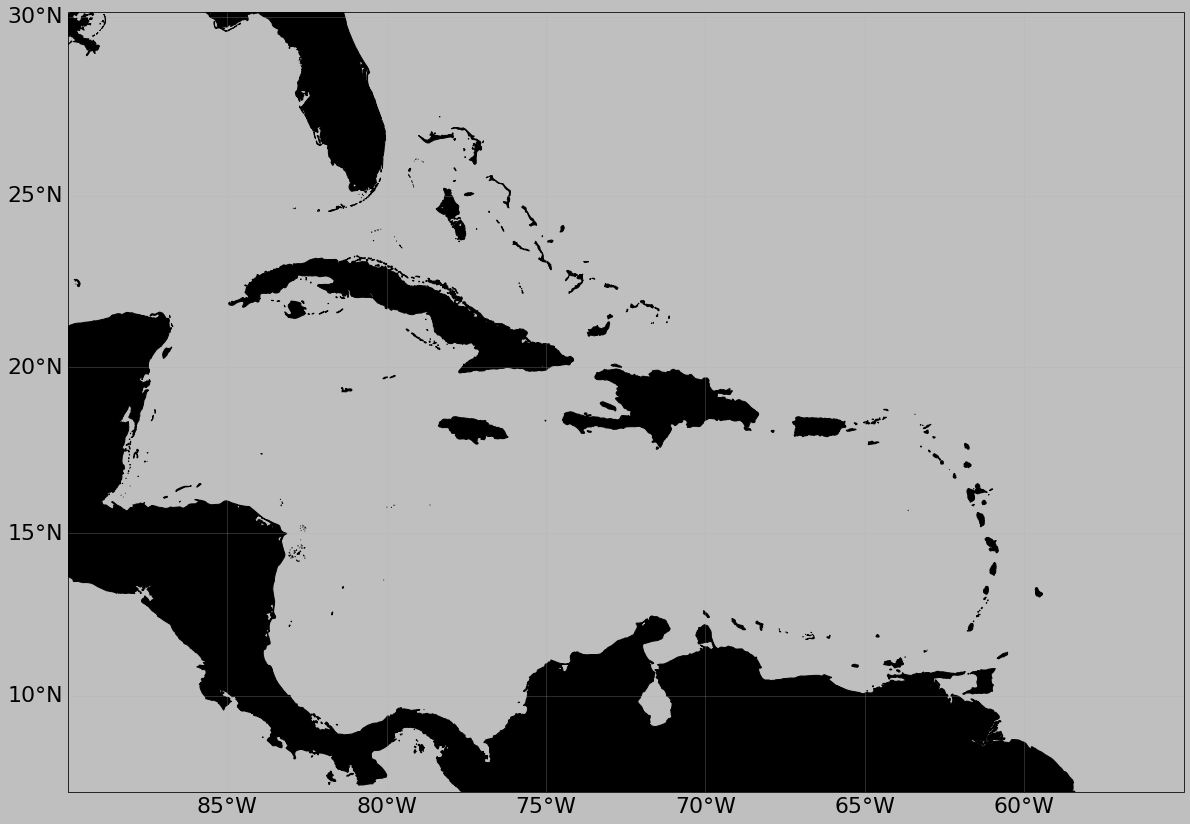

In [3]:
new_color='#BFBFBF'


fig, ax = plt.subplots(figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()),facecolor=new_color)

## Set lon and lat ranges
lon1 = -90
lon2 = -55
lat1 = 7
lat2 = 29

ax.set_facecolor(new_color)

ax.set_extent([lon1, lon2, lat1, lat2])

LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor='black'
)

ax.add_feature(LAND, zorder=0)

glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
glb.xlabel_style = {'size': 22}
glb.ylabel_style = {'size': 22}
glb.ylocator = mticker.FixedLocator([10, 15, 20, 25, 30])


plt.savefig('/home/jg1200/Figures/BLANK_CARIB_MAP_light_grey.png',dpi=300,facecolor=new_color,bbox_inches='tight')
